# 1. Import Dependencies

In [59]:
!pip install scikit-optimize

In [60]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from xgboost import XGBRegressor

import joblib


from sklearn.ensemble import GradientBoostingRegressor

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Read the Data

In [62]:
# read data
df = pd.read_csv('/content/drive/MyDrive/Dataset/Copy of joined_cty_vacc.csv')

In [63]:
df.head()

,country,country_code,year,BCG,DTP1,DTP3,HEPB3,HEPBB,HIB3,IPV1,IPV2,MCV1,MCV2,MENGA,PCV3,POL3,RCV1,ROTAC,YFV,life_expectancy
0,Afghanistan,AFG,2000,30.0,48.0,24.0,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,24.0,NaN,NaN,NaN,55.005
1,Afghanistan,AFG,2001,43.0,59.0,33.0,NaN,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,35.0,NaN,NaN,NaN,55.511
2,Afghanistan,AFG,2002,46.0,62.0,36.0,NaN,NaN,NaN,NaN,NaN,35.0,NaN,NaN,NaN,36.0,NaN,NaN,NaN,56.225
3,Afghanistan,AFG,2003,44.0,66.0,41.0,NaN,NaN,NaN,NaN,NaN,39.0,NaN,NaN,NaN,41.0,NaN,NaN,NaN,57.171
4,Afghanistan,AFG,2004,51.0,72.0,50.0,NaN,NaN,NaN,NaN,NaN,48.0,2.0,NaN,NaN,50.0,NaN,NaN,NaN,57.810


# 3. Basic Exploratory Data Analysis

In [64]:
# Basic information
print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          2267 non-null   object 
 1   country_code     2267 non-null   object 
 2   year             2267 non-null   int64  
 3   BCG              2193 non-null   float64
 4   DTP1             2267 non-null   float64
 5   DTP3             2267 non-null   float64
 6   HEPB3            1997 non-null   float64
 7   HEPBB            744 non-null    float64
 8   HIB3             1623 non-null   float64
 9   IPV1             777 non-null    float64
 10  IPV2             122 non-null    float64
 11  MCV1             2267 non-null   float64
 12  MCV2             1246 non-null   float64
 13  MENGA            68 non-null     float64
 14  PCV3             787 non-null    float64
 15  POL3             2267 non-null   float64
 16  RCV1             1157 non-null   float64
 17 

In [65]:
# Missing values analysis
print("\nMissing Values Analysis:")
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'column': missing_pct.index,
    'missing_pct': missing_pct.values
})
missing_df = missing_df[missing_df['missing_pct'] > 0].sort_values('missing_pct', ascending=False)
print(missing_df)


Missing Values Analysis:
   column  missing_pct
13  MENGA    97.000441
10   IPV2    94.618438
18    YFV    73.092192
17  ROTAC    72.077636
7   HEPBB    67.181297
9    IPV1    65.725629
14   PCV3    65.284517
16   RCV1    48.963388
12   MCV2    45.037494
8    HIB3    28.407587
6   HEPB3    11.910013
3     BCG     3.264226


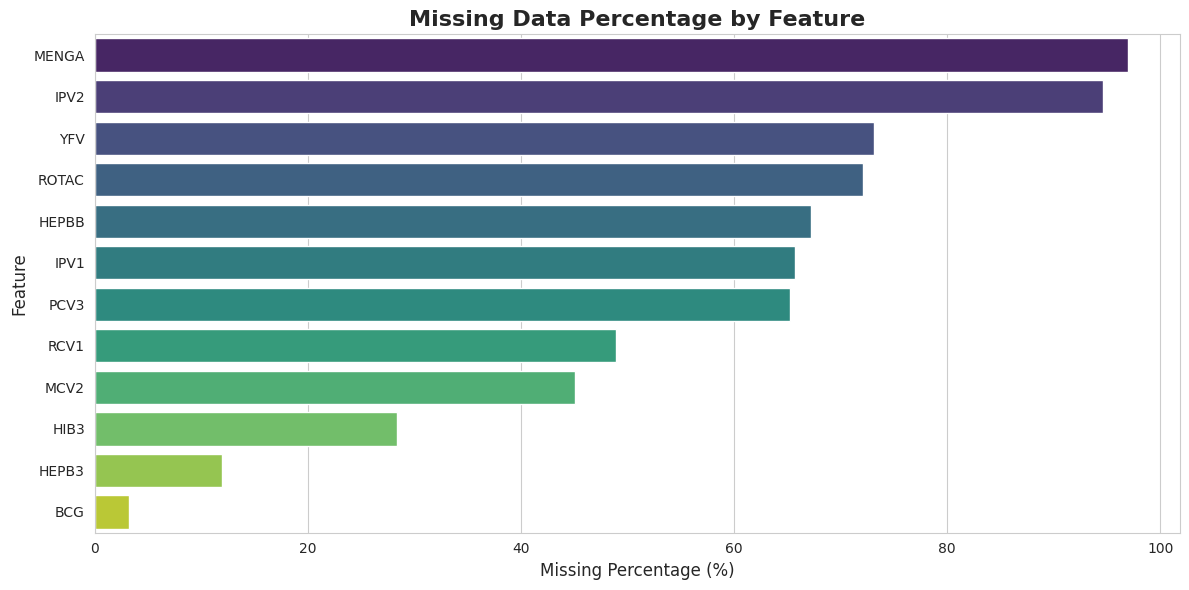

In [66]:
# Visualize missing data
plt.figure(figsize=(12, 6))
sns.barplot(data=missing_df, x='missing_pct', y='column', palette='viridis')
plt.title('Missing Data Percentage by Feature', fontsize=16, fontweight='bold')
plt.xlabel('Missing Percentage (%)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

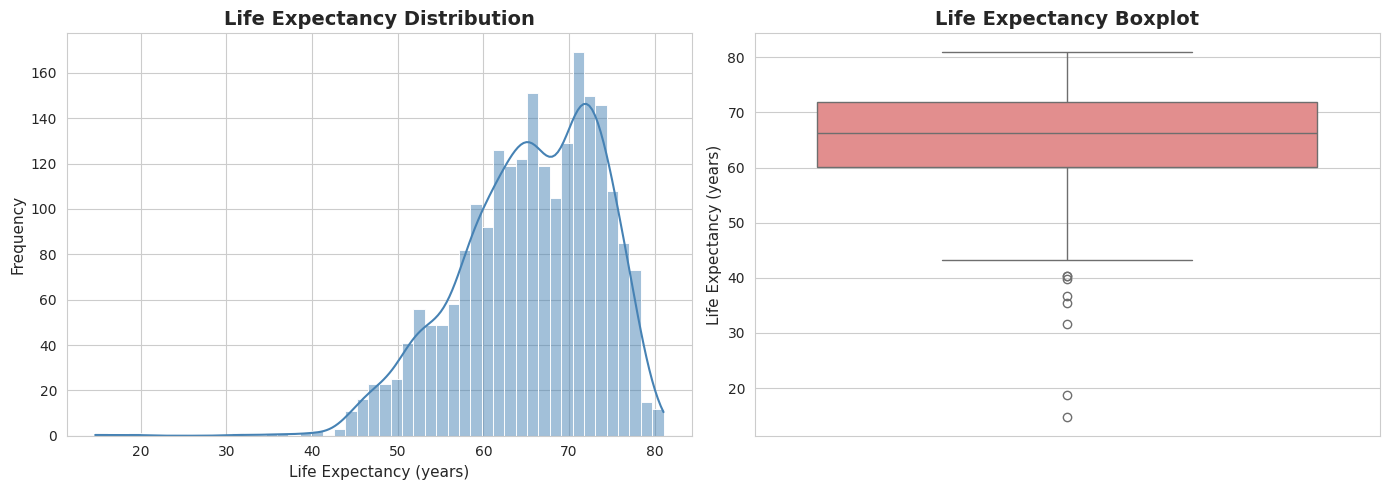


Life Expectancy Statistics:
Mean: 65.45 years
Median: 66.20 years
Std Dev: 8.22 years
Min: 14.66 years
Max: 81.04 years


In [67]:
# Target variable distribution
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['life_expectancy'].dropna(), bins=50, kde=True, color='steelblue')
plt.title('Life Expectancy Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Life Expectancy (years)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)

plt.subplot(1, 2, 2)
sns.boxplot(y=df['life_expectancy'], color='lightcoral')
plt.title('Life Expectancy Boxplot', fontsize=14, fontweight='bold')
plt.ylabel('Life Expectancy (years)', fontsize=11)
plt.tight_layout()
plt.show()

print(f"\nLife Expectancy Statistics:")
print(f"Mean: {df['life_expectancy'].mean():.2f} years")
print(f"Median: {df['life_expectancy'].median():.2f} years")
print(f"Std Dev: {df['life_expectancy'].std():.2f} years")
print(f"Min: {df['life_expectancy'].min():.2f} years")
print(f"Max: {df['life_expectancy'].max():.2f} years")

# 3. Data Cleaning

In [68]:
# Categorize columns by missing percentage
high_missing = missing_pct[missing_pct > 70].index.tolist()
medium_missing = missing_pct[(missing_pct > 30) & (missing_pct <= 70)].index.tolist()
low_missing = missing_pct[(missing_pct > 0) & (missing_pct <= 30)].index.tolist()

print(f"\nColumns with >70% missing (will be dropped): {len(high_missing)}")
print(high_missing)


Columns with >70% missing (will be dropped): 4
['IPV2', 'MENGA', 'ROTAC', 'YFV']


In [69]:
# Drop high missing columns
df_cleaned = df.drop(columns=high_missing)
print(f"\nDropped {len(high_missing)} columns with high missing data")


Dropped 4 columns with high missing data


In [70]:
# Impute remaining missing values
# df_cleaned = df_cleaned.sort_values(['country', 'year'])
# vaccine_cols = [col for col in df_cleaned.columns
#                 if col not in ['country', 'country_code', 'year', 'life_expectancy']]

# print(f"Imputing missing values for {len(vaccine_cols)} vaccine columns...")

# # Forward/backward fill within countries
# for col in vaccine_cols:
#     df_cleaned[col] = df_cleaned.groupby('country')[col].fillna(method='ffill').fillna(method='bfill')

# # Fill remaining with median
# for col in vaccine_cols:
#     df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

In [71]:
# Drop rows with missing life expectancy (target variable)
df_cleaned = df_cleaned.dropna(subset=['life_expectancy'])

print(f"Data cleaning complete: {df_cleaned.shape[0]} rows, {df_cleaned.shape[1]} columns")
print(f"Remaining missing values: {df_cleaned.isnull().sum().sum()}")

Data cleaning complete: 2267 rows, 16 columns
Remaining missing values: 7612


In [72]:
# Sort by country and year for time-series operations
df_cleaned = df_cleaned.sort_values(['country', 'year'])

# Identify vaccine columns for later imputation
vaccine_cols = [col for col in df_cleaned.columns
                if col not in ['country', 'country_code', 'year', 'life_expectancy']]

In [73]:
# Analyze features for imputation
# Analyze distribution of numerical features on NON-MISSING data only
numerical_cols = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['country_code']]

In [74]:
# Distribution statistics on observed data only
distribution_stats = []
for col in numerical_cols:
    observed_data = df_cleaned[col].dropna()
    if len(observed_data) > 0:
        skewness = stats.skew(observed_data)
        kurtosis = stats.kurtosis(observed_data)
        missing_pct = (df_cleaned[col].isna().sum() / len(df_cleaned)) * 100

        distribution_stats.append({
            'feature': col,
            'n_observed': len(observed_data),
            'missing_pct': missing_pct,
            'mean': observed_data.mean(),
            'median': observed_data.median(),
            'std': observed_data.std(),
            'skewness': skewness,
            'kurtosis': kurtosis,
            'min': observed_data.min(),
            'max': observed_data.max()
        })

dist_df = pd.DataFrame(distribution_stats).sort_values('skewness', key=abs, ascending=False)
print("Distribution Statistics (sorted by absolute skewness):")
print("Features with |skewness| > 1 may need transformation:")
print(dist_df.head(15).to_string(index=False))

Distribution Statistics (sorted by absolute skewness):
Features with |skewness| > 1 may need transformation:
        feature  n_observed  missing_pct        mean   median       std  skewness  kurtosis      min      max
           RCV1        1157    48.963388   87.466724   91.000 12.514834 -2.046348  5.718540    6.000   99.000
            BCG        2193     3.264226   88.863201   93.000 11.900802 -1.756994  3.524419   28.000   99.000
           HIB3        1623    28.407587   82.932224   88.000 16.054749 -1.642762  3.030726    1.000   99.000
          HEPB3        1997    11.910013   82.603405   88.000 16.450264 -1.638138  3.171736    2.000   99.000
           DTP1        2267     0.000000   88.653727   93.000 11.864362 -1.591397  2.427772   35.000   99.000
           PCV3         787    65.284517   75.838628   83.000 22.542990 -1.517723  1.768132    0.000   99.000
           IPV1         777    65.725629   76.849421   84.000 22.749742 -1.453537  1.772586    0.000   99.000
           

In [75]:
# Identify highly skewed features
highly_skewed = dist_df[dist_df['skewness'].abs() > 1]['feature'].tolist()
print(f"{len(highly_skewed)} features with high skewness (|skew| > 1):")
print(highly_skewed[:10])

11 features with high skewness (|skew| > 1):
['RCV1', 'BCG', 'HIB3', 'HEPB3', 'DTP1', 'PCV3', 'IPV1', 'DTP3', 'POL3', 'HEPBB']


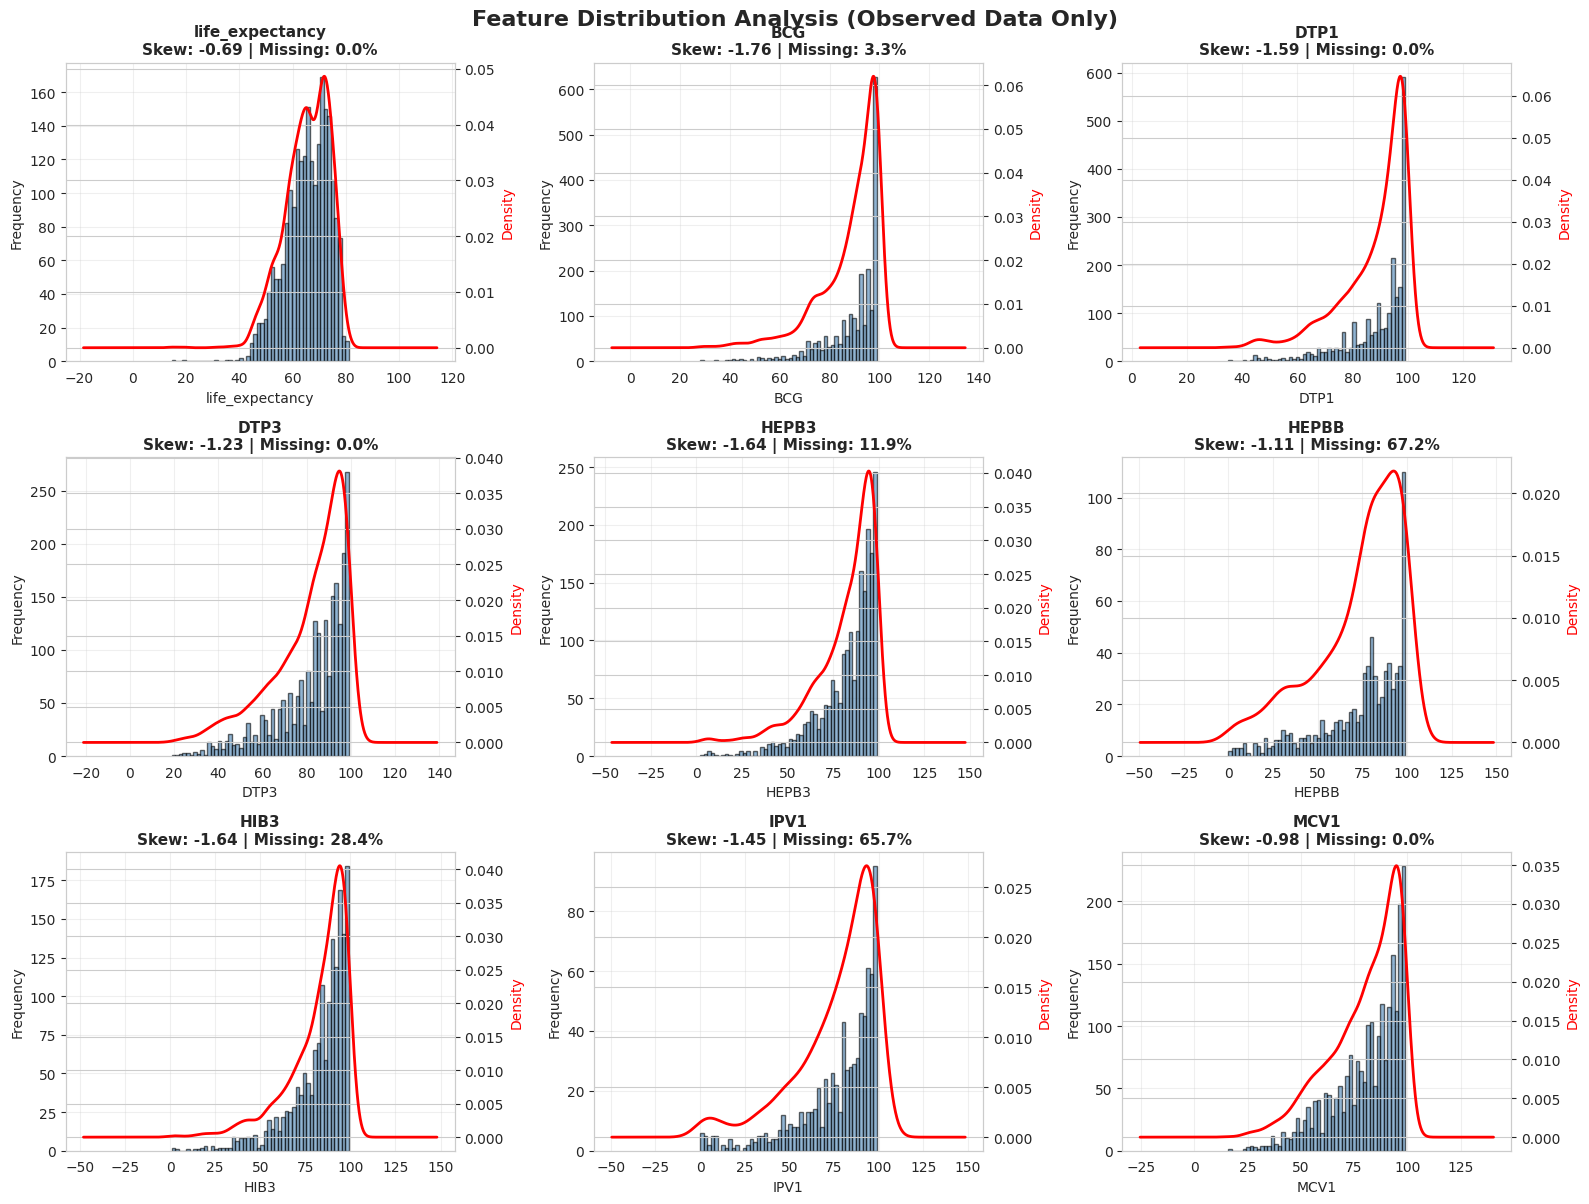

In [76]:
# Visualize distributions of key features (on observed data)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

# Select features with sufficient data
key_features_analysis = ['life_expectancy'] + [col for col in vaccine_cols[:8]
                                                if df_cleaned[col].notna().sum() > 100]

for idx, col in enumerate(key_features_analysis[:9]):
    if idx < 9:
        ax = axes[idx]

        # Get observed data only
        observed = df_cleaned[col].dropna()
        missing_count = df_cleaned[col].isna().sum()
        missing_pct = (missing_count / len(df_cleaned)) * 100

        # Histogram with KDE
        ax.hist(observed, bins=50, alpha=0.6, color='steelblue', edgecolor='black')
        ax2 = ax.twinx()
        observed.plot(kind='kde', ax=ax2, color='red', linewidth=2)

        skew_val = stats.skew(observed)
        ax.set_xlabel(col, fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax2.set_ylabel('Density', fontsize=10, color='red')
        ax.set_title(f'{col}\nSkew: {skew_val:.2f} | Missing: {missing_pct:.1f}%',
                     fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Feature Distribution Analysis (Observed Data Only)',
             fontsize=16, fontweight='bold', y=1.00)
plt.show()

In [77]:
# Outliers detection
# Function to detect outliers using IQR method
def detect_outliers_iqr(data, column, multiplier=1.5):
    """Detect outliers using Interquartile Range method"""
    observed = data[column].dropna()
    Q1 = observed.quantile(0.25)
    Q3 = observed.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

In [78]:
# Detect outliers in life expectancy (target variable)
print("Life Expectancy Outliers:")
outliers_iqr, lower, upper = detect_outliers_iqr(df_cleaned, 'life_expectancy')
print(f"IQR Method: {len(outliers_iqr)} outliers detected")
print(f"Lower bound: {lower:.2f}, Upper bound: {upper:.2f}")

Life Expectancy Outliers:
IQR Method: 8 outliers detected
Lower bound: 42.36, Upper bound: 89.76


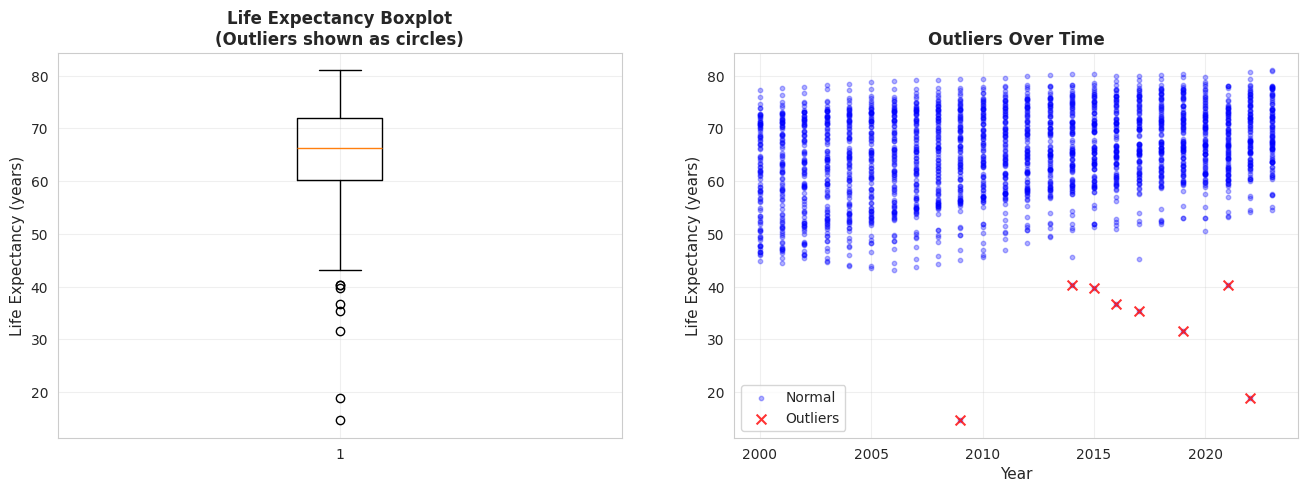

In [79]:
# Visualize outliers with boxplot and scatter
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Boxplot
axes[0].boxplot(df_cleaned['life_expectancy'].dropna(), vert=True)
axes[0].set_ylabel('Life Expectancy (years)', fontsize=11)
axes[0].set_title('Life Expectancy Boxplot\n(Outliers shown as circles)',
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Scatter plot over time
axes[1].scatter(df_cleaned['year'], df_cleaned['life_expectancy'],
                alpha=0.3, s=10, c='blue', label='Normal')
if len(outliers_iqr) > 0:
    axes[1].scatter(outliers_iqr['year'], outliers_iqr['life_expectancy'],
                    alpha=0.8, s=50, c='red', marker='x', label='Outliers')
axes[1].set_xlabel('Year', fontsize=11)
axes[1].set_ylabel('Life Expectancy (years)', fontsize=11)
axes[1].set_title('Outliers Over Time', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

In [80]:
# Detect outliers in vaccination features (on observed data)
print("Vaccination Coverage Outliers:")
outlier_summary = []

features_to_check = [col for col in vaccine_cols[:15] if df_cleaned[col].notna().sum() > 100]
for col in features_to_check:
    outliers, lower, upper = detect_outliers_iqr(df_cleaned, col)
    observed_count = df_cleaned[col].notna().sum()
    outlier_summary.append({
        'feature': col,
        'n_outliers': len(outliers),
        'pct_outliers': (len(outliers) / observed_count) * 100,
        'lower_bound': lower,
        'upper_bound': upper
    })

outlier_summary_df = pd.DataFrame(outlier_summary).sort_values('n_outliers', ascending=False)
print("Top 10 features with outliers:")
print(outlier_summary_df.head(10).to_string(index=False))

Vaccination Coverage Outliers:
Top 10 features with outliers:
feature  n_outliers  pct_outliers  lower_bound  upper_bound
    BCG          93      4.240766        63.00       119.00
   DTP1          79      3.484782        60.50       120.50
   HIB3          78      4.805915        47.50       123.50
  HEPB3          77      3.855784        45.00       125.00
   DTP3          74      3.264226        42.50       126.50
   RCV1          65      5.617978        63.50       115.50
   PCV3          53      6.734435        30.75       128.75
   IPV1          35      4.504505        26.50       134.50
   POL3          34      1.499779        40.00       128.00
   MCV2          32      2.568218        19.50       135.50


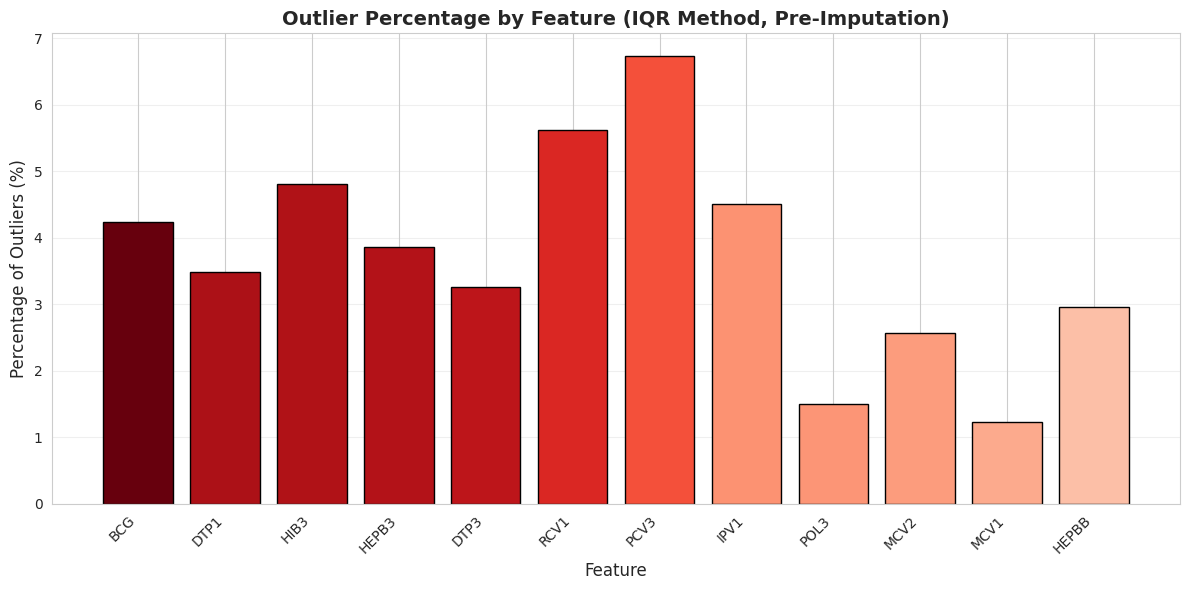

In [81]:
# Visualize outlier counts
if len(outlier_summary_df) > 0:
    plt.figure(figsize=(12, 6))
    colors = plt.cm.Reds(outlier_summary_df['n_outliers'] / outlier_summary_df['n_outliers'].max())
    plt.bar(range(len(outlier_summary_df)), outlier_summary_df['pct_outliers'],
            color=colors, edgecolor='black')
    plt.xticks(range(len(outlier_summary_df)), outlier_summary_df['feature'], rotation=45, ha='right')
    plt.xlabel('Feature', fontsize=12)
    plt.ylabel('Percentage of Outliers (%)', fontsize=12)
    plt.title('Outlier Percentage by Feature (IQR Method, Pre-Imputation)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

In [82]:
# Imputation after distribution analysis
# Strategy 1: Forward/Backward fill within countries (preserves temporal patterns)
print("Strategy 1: Temporal imputation (forward/backward fill within countries)")
for col in vaccine_cols:
    initial_missing = df_cleaned[col].isnull().sum()
    df_cleaned[col] = df_cleaned.groupby('country')[col].fillna(method='ffill').fillna(method='bfill')
    filled = initial_missing - df_cleaned[col].isnull().sum()
    if filled > 0:
        print(f"  {col}: filled {filled} values using temporal interpolation")

Strategy 1: Temporal imputation (forward/backward fill within countries)
  BCG: filled 74 values using temporal interpolation
  HEPB3: filled 270 values using temporal interpolation
  HEPBB: filled 1475 values using temporal interpolation
  HIB3: filled 644 values using temporal interpolation
  IPV1: filled 1490 values using temporal interpolation
  MCV2: filled 1021 values using temporal interpolation
  PCV3: filled 1480 values using temporal interpolation
  RCV1: filled 1110 values using temporal interpolation


In [83]:
# Strategy 2: For remaining gaps, use conditional mean by decade
print("Strategy 2: Conditional imputation (by decade)")
df_cleaned['decade'] = (df_cleaned['year'] // 10) * 10

for col in vaccine_cols:
    if df_cleaned[col].isnull().sum() > 0:
        initial_missing = df_cleaned[col].isnull().sum()

        # Fill with decade+region mean
        df_cleaned[col] = df_cleaned.groupby(['decade'])[col].transform(
            lambda x: x.fillna(x.mean())
        )

        # If still missing, use global median (most conservative)
        if df_cleaned[col].isnull().sum() > 0:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

        filled = initial_missing - df_cleaned[col].isnull().sum()
        if filled > 0:
            print(f"{col}: filled {filled} values using decade means")

Strategy 2: Conditional imputation (by decade)
HEPBB: filled 48 values using decade means


In [84]:
print(f"Remaining missing values: {df_cleaned.isnull().sum().sum()}")

Remaining missing values: 0


# 4. Exploratory Data Analysis

In [85]:
# Correlation with life expectancy
correlations = df_cleaned[vaccine_cols + ['life_expectancy']].corr()['life_expectancy'].sort_values(ascending=False)
print("Top 10 Features Correlated with Life Expectancy:")
print(correlations[1:11])

Top 10 Features Correlated with Life Expectancy:
MCV1     0.582734
MCV2     0.562651
DTP3     0.559149
POL3     0.550644
DTP1     0.507250
BCG      0.465443
HEPB3    0.459225
IPV1     0.409985
HIB3     0.340356
PCV3     0.196166
Name: life_expectancy, dtype: float64


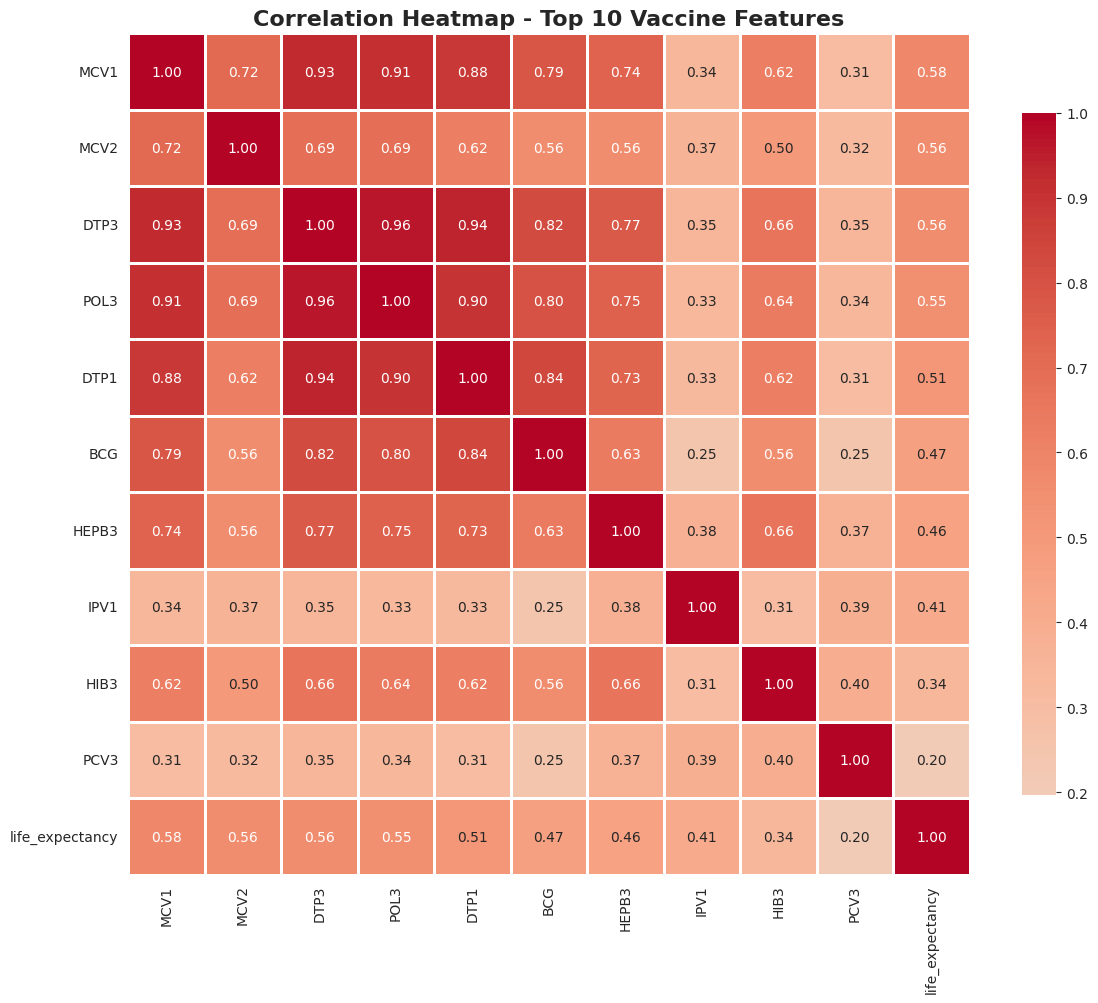

In [86]:
# Correlation heatmap
top_features = correlations[1:11].index.tolist()
plt.figure(figsize=(12, 10))
corr_matrix = df_cleaned[top_features + ['life_expectancy']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Top 10 Vaccine Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [87]:
yearly_avg = df_cleaned.groupby(['year', 'country'])['life_expectancy'].mean().reset_index()

# Calculate overall average life expectancy for each country
country_avg_life_expectancy = df_cleaned.groupby('country')['life_expectancy'].mean().sort_values(ascending=False)

# Get top 5 and bottom 5 countries
top_5_countries = country_avg_life_expectancy.head(5).index.tolist()
bottom_5_countries = country_avg_life_expectancy.tail(5).index.tolist()

# Combine top 5 and bottom 5 for plotting
# selected_countries = top_5_countries + bottom_5_countries

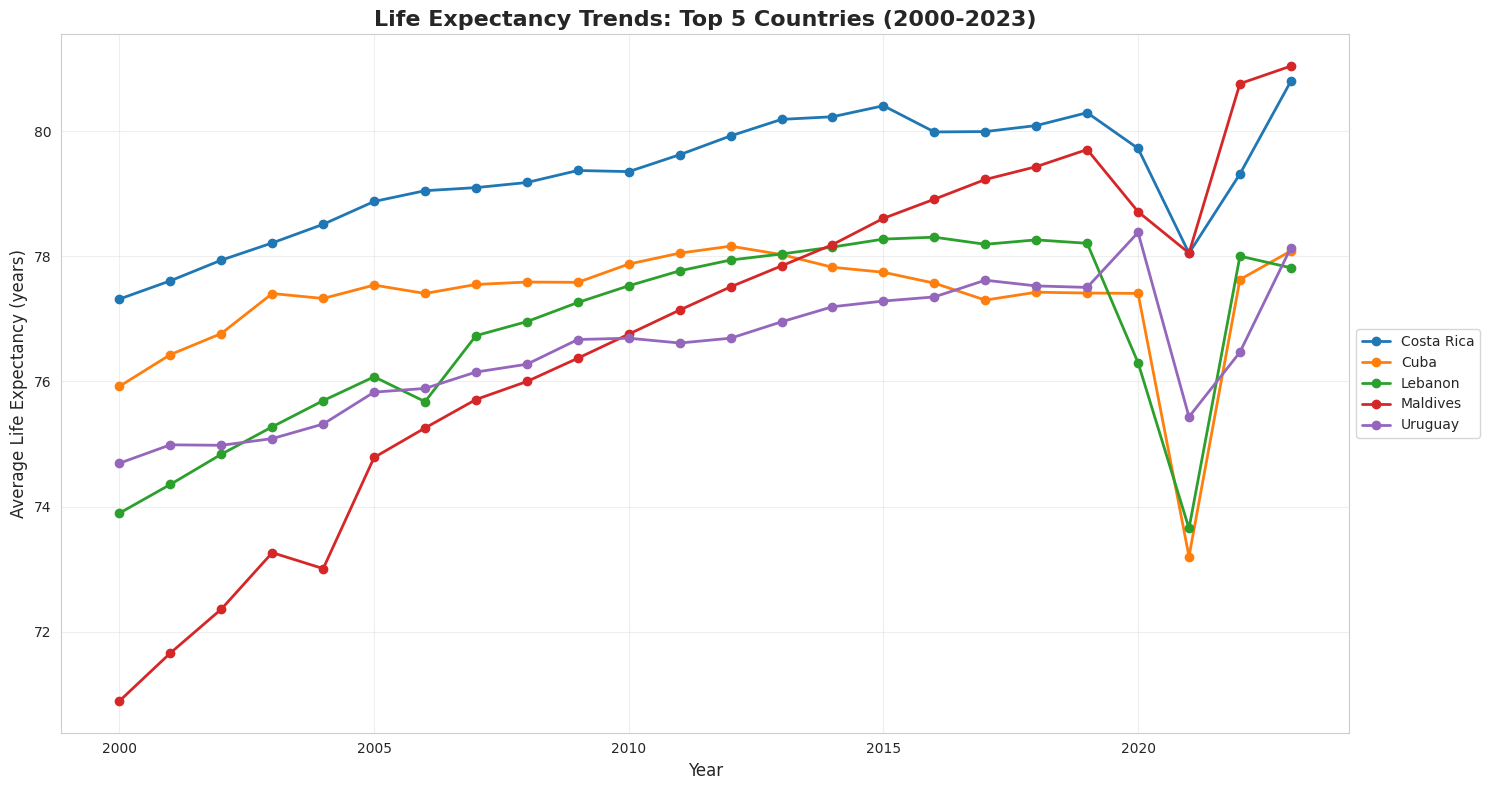

In [88]:
# Plot the top 5 country by mean life expectancy
plt.figure(figsize=(15, 8))
for country in top_5_countries:
    region_data = yearly_avg[yearly_avg['country'] == country]
    plt.plot(region_data['year'], region_data['life_expectancy'],
             marker='o', label=f'{country}', linewidth=2)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Life Expectancy (years)', fontsize=12)
plt.title('Life Expectancy Trends: Top 5 Countries (2000-2023)', fontsize=16, fontweight='bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

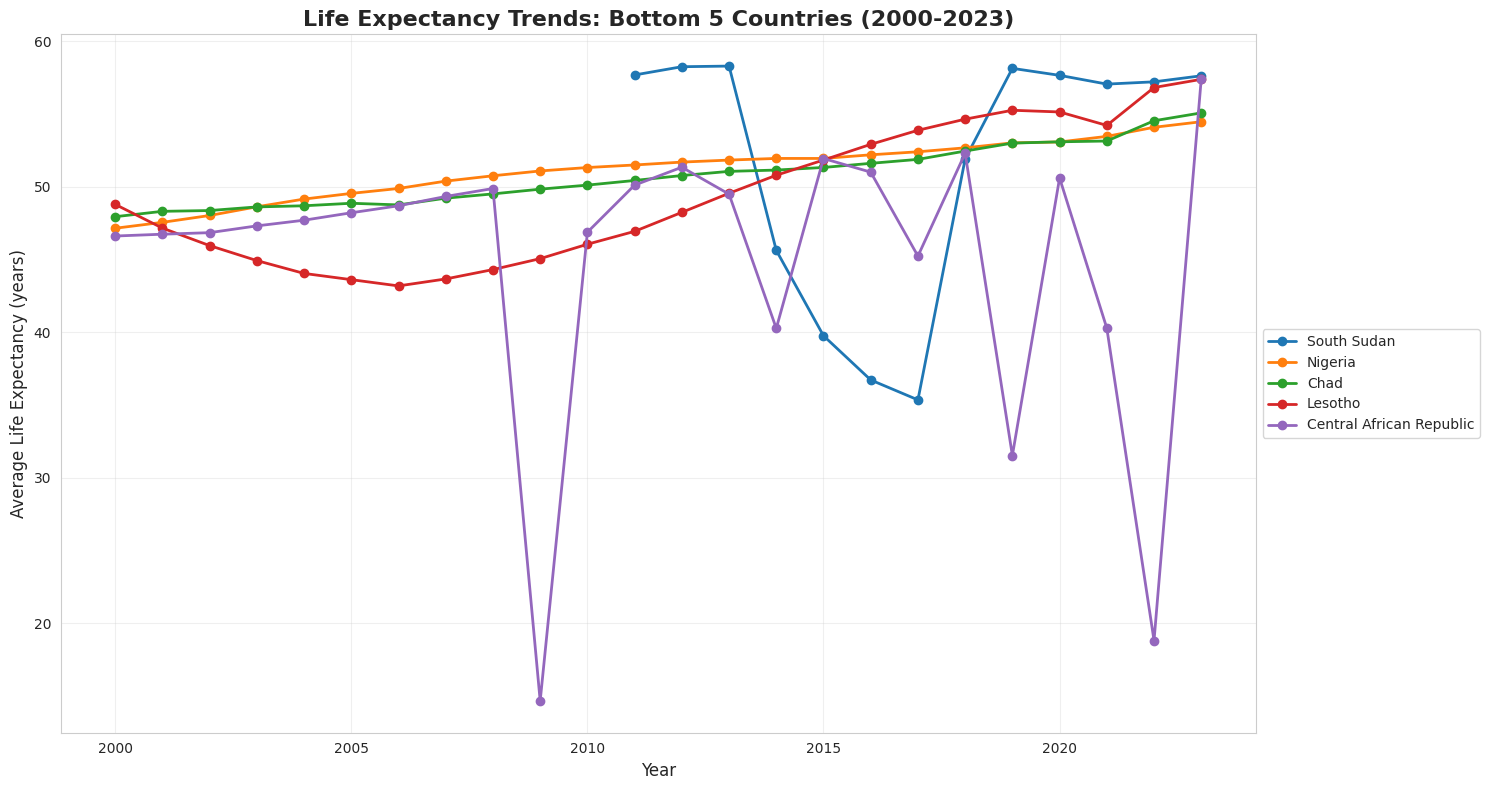

In [89]:
# Plot the bottom 5 country by mean life expectancy
plt.figure(figsize=(15, 8))
for country in bottom_5_countries:
    region_data = yearly_avg[yearly_avg['country'] == country]
    plt.plot(region_data['year'], region_data['life_expectancy'],
             marker='o', label=f'{country}', linewidth=2)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Life Expectancy (years)', fontsize=12)
plt.title('Life Expectancy Trends: Bottom 5 Countries (2000-2023)', fontsize=16, fontweight='bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

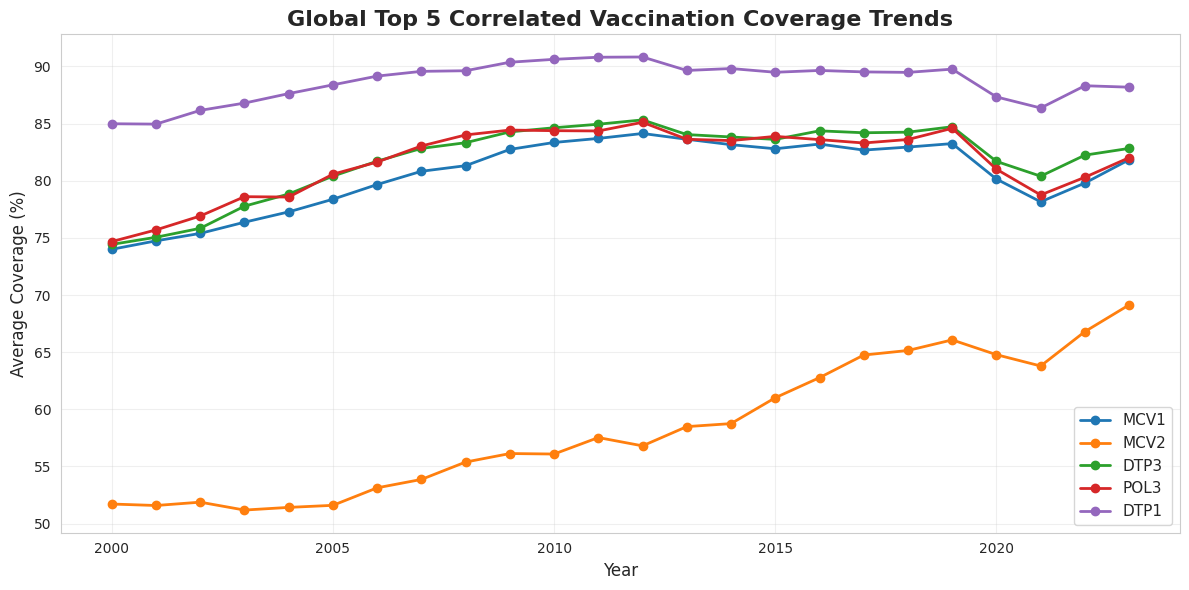

In [90]:
# 5 best correlated vaccine coverage over time
avg_coverage = df_cleaned.groupby('year')[correlations[1:6].index].mean()
plt.figure(figsize=(14, 6))
avg_coverage.plot(marker='o', linewidth=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Coverage (%)', fontsize=12)
plt.title('Global Top 5 Correlated Vaccination Coverage Trends', fontsize=16, fontweight='bold')
plt.legend(correlations[1:6].index.tolist(), fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

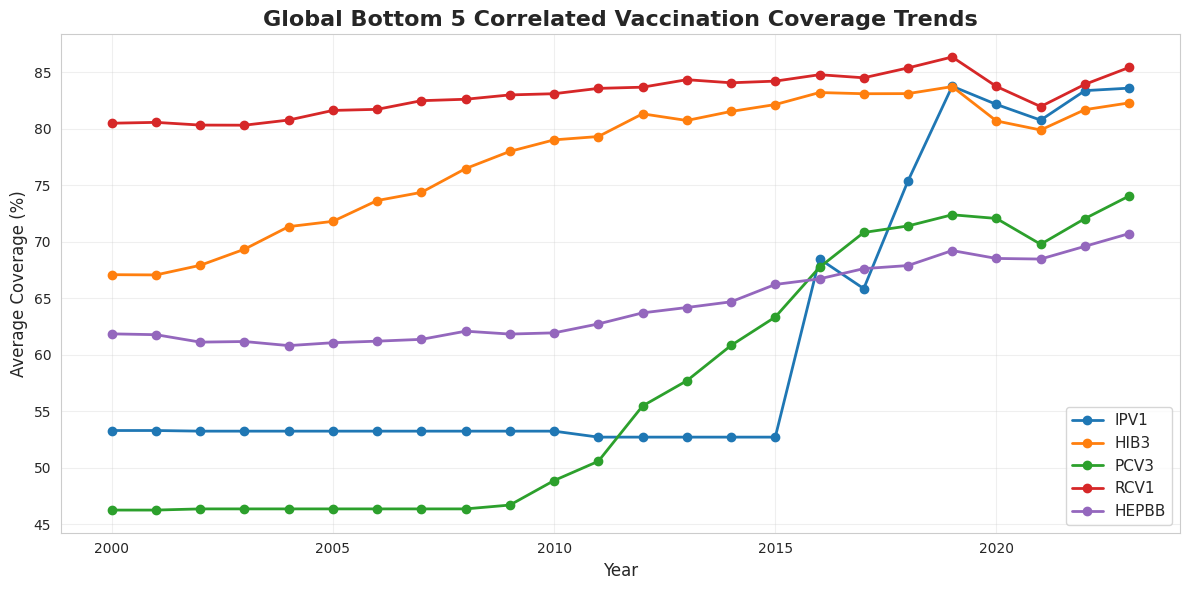

In [91]:
# 5 least correlated vaccine coverage over time
avg_coverage = df_cleaned.groupby('year')[correlations[-5:].index].mean()
plt.figure(figsize=(14, 6))
avg_coverage.plot(marker='o', linewidth=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Coverage (%)', fontsize=12)
plt.title('Global Bottom 5 Correlated Vaccination Coverage Trends', fontsize=16, fontweight='bold')
plt.legend(correlations[-5:].index.tolist(), fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Feature Engineering

In [92]:
# Vaccination coverage index
# key_vaccines = [col for col in ['DTP3', 'MCV1', 'POL3', 'BCG'] if col in df_cleaned.columns]
df_cleaned['vacc_coverage_index'] = df_cleaned[vaccine_cols].mean(axis=1)
print(f"Created vaccination coverage index from {len(vaccine_cols)} vaccines")

Created vaccination coverage index from 12 vaccines


In [93]:
# Temporal features
df_cleaned['years_since_2000'] = df_cleaned['year'] - 2000
df_cleaned['decade'] = (df_cleaned['year'] // 10) * 10
print("Created temporal features")

Created temporal features


In [94]:
# # Country-level historical average
# df_cleaned = df_cleaned.sort_values(['country', 'year'])
# df_cleaned['country_avg_life_exp'] = df_cleaned.groupby('country')['life_expectancy'].transform(
#     lambda x: x.shift(1).expanding().mean()
# )
# df_cleaned['country_avg_life_exp'] = df_cleaned['country_avg_life_exp'].fillna(
#     df_cleaned.groupby('country')['life_expectancy'].transform('mean')
# )
# print("Created country historical average feature")

In [95]:
# Vaccination improvement rate
df_cleaned['vacc_improvement'] = df_cleaned.groupby('country')['vacc_coverage_index'].diff()
df_cleaned['vacc_improvement'] = df_cleaned['vacc_improvement'].fillna(0)
print("Created vaccination improvement rate feature")

Created vaccination improvement rate feature


In [96]:
# Encode country
le_country = LabelEncoder()
df_cleaned['country_encoded'] = le_country.fit_transform(df_cleaned['country'])
print("Encoded country names")

Encoded country names


In [97]:
print(f"\nFinal dataset shape: {df_cleaned.shape}")
display(df_cleaned.head())


Final dataset shape: (2267, 21)


,country,country_code,year,BCG,DTP1,DTP3,HEPB3,HEPBB,HIB3,IPV1,...,MCV2,PCV3,POL3,RCV1,life_expectancy,decade,vacc_coverage_index,years_since_2000,vacc_improvement,country_encoded
0,Afghanistan,AFG,2000,30.0,48.0,24.0,63.0,4.0,63.0,65.0,...,2.0,49.0,24.0,88.0,55.005,2000,40.583333,0,0.000000,0
1,Afghanistan,AFG,2001,43.0,59.0,33.0,63.0,4.0,63.0,65.0,...,2.0,49.0,35.0,88.0,55.511,2000,45.083333,1,4.500000,0
2,Afghanistan,AFG,2002,46.0,62.0,36.0,63.0,4.0,63.0,65.0,...,2.0,49.0,36.0,88.0,56.225,2000,45.750000,2,0.666667,0
3,Afghanistan,AFG,2003,44.0,66.0,41.0,63.0,4.0,63.0,65.0,...,2.0,49.0,41.0,88.0,57.171,2000,47.083333,3,1.333333,0
4,Afghanistan,AFG,2004,51.0,72.0,50.0,63.0,4.0,63.0,65.0,...,2.0,49.0,50.0,88.0,57.810,2000,50.416667,4,3.333333,0


# 6. Model Preparation

In [98]:
# Define features and target
exclude_cols = ['country', 'country_code', 'year', 'life_expectancy']
feature_cols = [col for col in df_cleaned.columns if col not in exclude_cols]

X = df_cleaned[feature_cols]
y = df_cleaned['life_expectancy']

print(f"Features: {len(feature_cols)}")
print(f"Samples: {len(X)}")

Features: 17
Samples: 2267


In [115]:
feature_cols

['BCG',
 'DTP1',
 'DTP3',
 'HEPB3',
 'HEPBB',
 'HIB3',
 'IPV1',
 'MCV1',
 'MCV2',
 'PCV3',
 'POL3',
 'RCV1',
 'decade',
 'vacc_coverage_index',
 'years_since_2000',
 'vacc_improvement',
 'country_encoded']

In [99]:
# Train-test split (stratified by decade)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df_cleaned['decade']
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (1813, 17)
Test set: (454, 17)


In [100]:
X_train.head()

,BCG,DTP1,DTP3,HEPB3,HEPBB,HIB3,IPV1,MCV1,MCV2,PCV3,POL3,RCV1,decade,vacc_coverage_index,years_since_2000,vacc_improvement,country_encoded
713,73.0,76.0,65.0,65.0,99.0,65.0,48.0,59.0,35.0,64.0,67.0,81.0,2010,66.416667,17,0.833333,29
130,98.0,99.0,96.0,96.0,55.0,96.0,7.0,98.0,91.0,36.0,96.0,98.0,2010,80.500000,10,-0.416667,5
537,90.0,90.0,89.0,89.0,87.0,89.0,46.0,84.0,82.0,82.0,89.0,81.0,2000,83.166667,9,1.000000,22
333,92.0,92.0,86.0,86.0,82.0,86.0,87.0,83.0,63.0,86.0,88.0,83.0,2020,84.500000,21,-1.750000,13
1835,94.0,97.0,91.0,92.0,61.0,92.0,7.0,77.0,54.0,42.0,97.0,76.0,2010,73.333333,11,3.583333,76


In [101]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled using StandardScaler")

Features scaled using StandardScaler


# 7. Model Training

In [102]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbosity=0)
}


In [103]:
# Train and evaluate all models
results = []
predictions = {}

for name, model in models.items():
    print(f"Training {name}...")

    # Use scaled data for Linear Regression, original for tree-based
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })

    predictions[name] = y_pred

    print(f"MAE: {mae:.3f} years")
    print(f"RMSE: {rmse:.3f} years")
    print(f"R²: {r2:.4f}")
    print()


Training Linear Regression...
MAE: 4.585 years
RMSE: 6.144 years
R²: 0.4534

Training Random Forest...
MAE: 1.496 years
RMSE: 2.843 years
R²: 0.8830

Training Gradient Boosting...
MAE: 1.648 years
RMSE: 2.916 years
R²: 0.8769

Training XGBoost...
MAE: 1.694 years
RMSE: 3.048 years
R²: 0.8655



In [104]:
# Display results
results_df = pd.DataFrame(results).sort_values('R²', ascending=False)
print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)
print(results_df.to_string(index=False))


MODEL COMPARISON
            Model      MAE     RMSE       R²
    Random Forest 1.495567 2.842982 0.882958
Gradient Boosting 1.648492 2.915547 0.876907
          XGBoost 1.693890 3.047503 0.865513
Linear Regression 4.585467 6.143955 0.453376


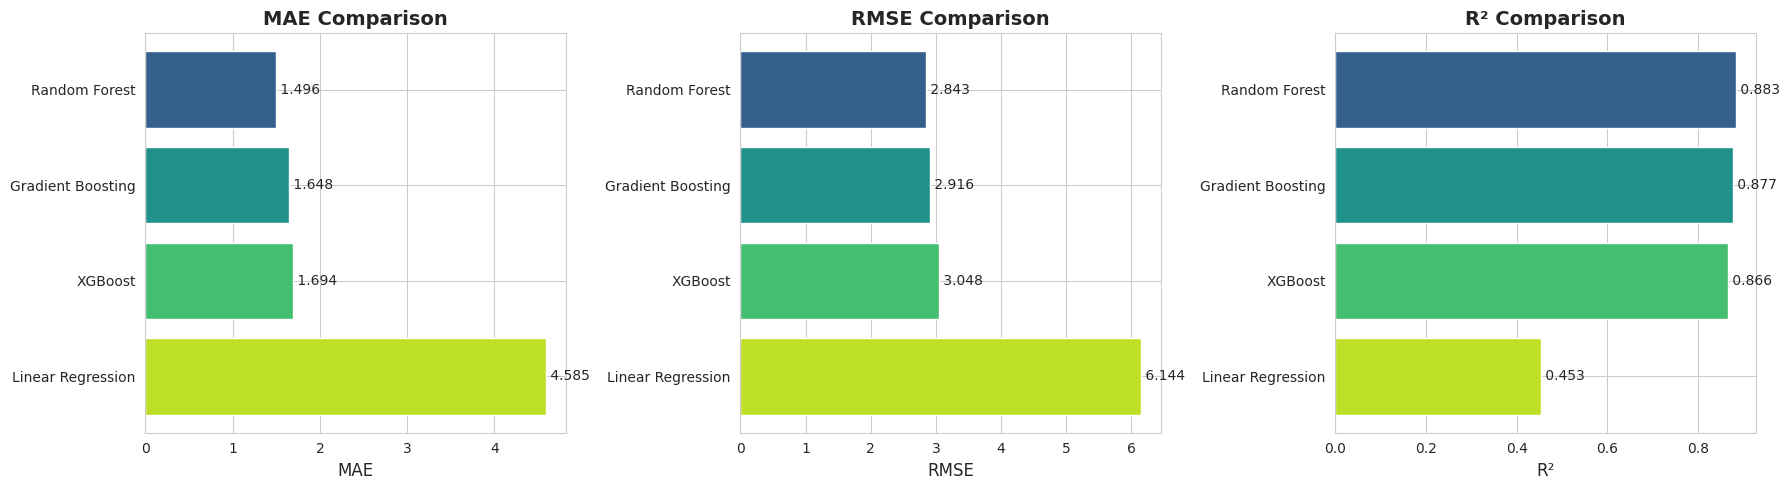

In [105]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(['MAE', 'RMSE', 'R²']):
    ax = axes[idx]
    data = results_df.sort_values(metric, ascending=(metric != 'R²'))
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(data)))
    ax.barh(data['Model'], data[metric], color=colors)
    ax.set_xlabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.invert_yaxis()

    # Add values on bars
    for i, v in enumerate(data[metric]):
        ax.text(v, i, f' {v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# 8. Hyperparameter Tuning

In [106]:
# Get the best model
best_model_name = results_df.iloc[0]['Model']
print(f"Tuning {best_model_name}")

Tuning Random Forest


In [107]:
# Using BayesSearch instead of GridSearch for optimization
# Define the search space (instead of a fixed grid)
search_space = {
    'n_estimators': Integer(100, 1000),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 12),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'subsample': Real(0.5, 1.0)
}


# Initialize the Bayesian Search (Gaussian Process)
# n_iter=32 means it will try 32 different combinations intelligently
opt = BayesSearchCV(
    GradientBoostingRegressor(),
    search_space,
    n_iter=32,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    random_state=42
)

# Execute the search
print("Starting Bayesian Optimization...")
opt.fit(X_train, y_train)

# Results
print("Best Parameters Found:", opt.best_params_)
print(f"Best MAE: {-opt.best_score_:.4f}")

Starting Bayesian Optimization...
Best Parameters Found: OrderedDict({'learning_rate': 0.01, 'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 915, 'subsample': 0.6681789940605407})
Best MAE: 1.5389


In [108]:
# Final model
final_model = opt.best_estimator_
y_pred_final = final_model.predict(X_test)

# Final evaluation
mae_final = mean_absolute_error(y_test, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2_final = r2_score(y_test, y_pred_final)

print("\n" + "=" * 80)
print("FINAL MODEL PERFORMANCE")
print("=" * 80)
print(f"MAE:  {mae_final:.3f} years")
print(f"RMSE: {rmse_final:.3f} years")
print(f"R²:   {r2_final:.4f}")


FINAL MODEL PERFORMANCE
MAE:  1.217 years
RMSE: 2.562 years
R²:   0.9049


# 9. Model Evaluation & Interpretation

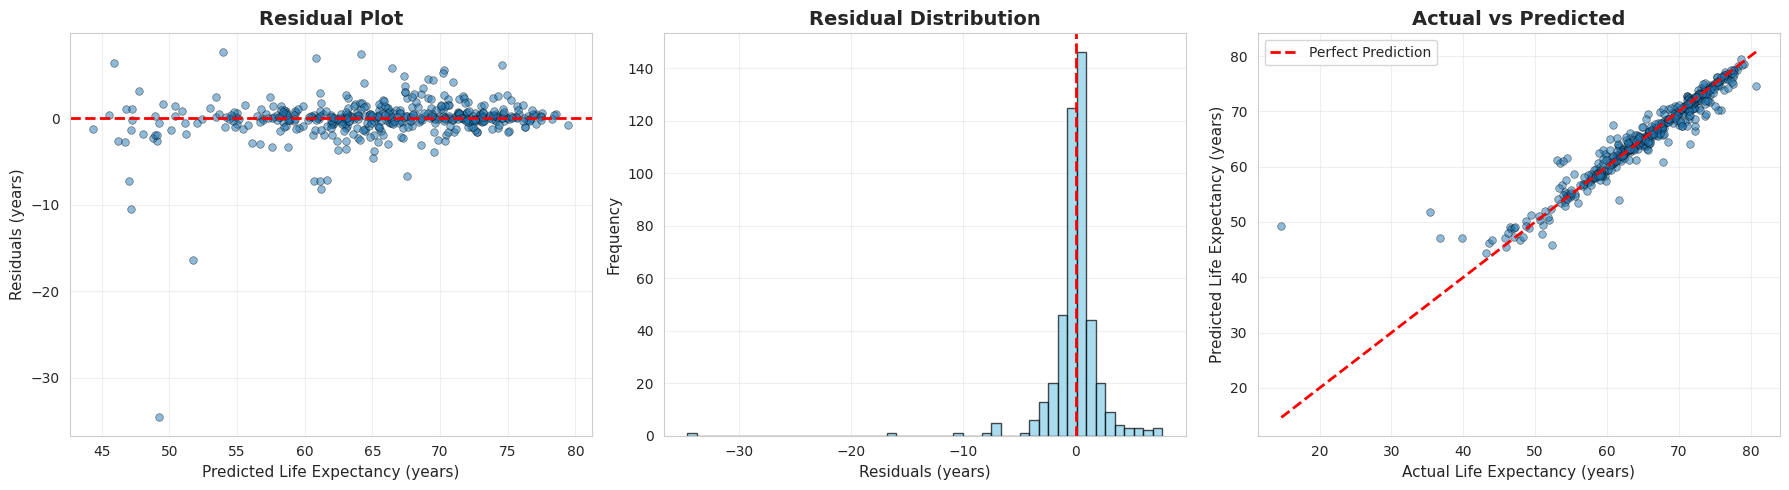

In [109]:
# Residual analysis
residuals = y_test.values - y_pred_final

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residual plot
axes[0].scatter(y_pred_final, residuals, alpha=0.5, s=30, edgecolors='k', linewidth=0.5)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Life Expectancy (years)', fontsize=11)
axes[0].set_ylabel('Residuals (years)', fontsize=11)
axes[0].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residual distribution
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals (years)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Residual Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Actual vs Predicted
axes[2].scatter(y_test, y_pred_final, alpha=0.5, s=30, edgecolors='k', linewidth=0.5)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[2].set_xlabel('Actual Life Expectancy (years)', fontsize=11)
axes[2].set_ylabel('Predicted Life Expectancy (years)', fontsize=11)
axes[2].set_title('Actual vs Predicted', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [110]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))



Top 15 Most Important Features:
            feature  importance
               IPV1    0.266386
               MCV2    0.175073
               MCV1    0.097657
    country_encoded    0.090009
              HEPBB    0.075578
   years_since_2000    0.060475
               PCV3    0.058430
               RCV1    0.047946
vacc_coverage_index    0.024336
               HIB3    0.017667
               POL3    0.017007
                BCG    0.014135
              HEPB3    0.013898
               DTP3    0.013153
   vacc_improvement    0.011585


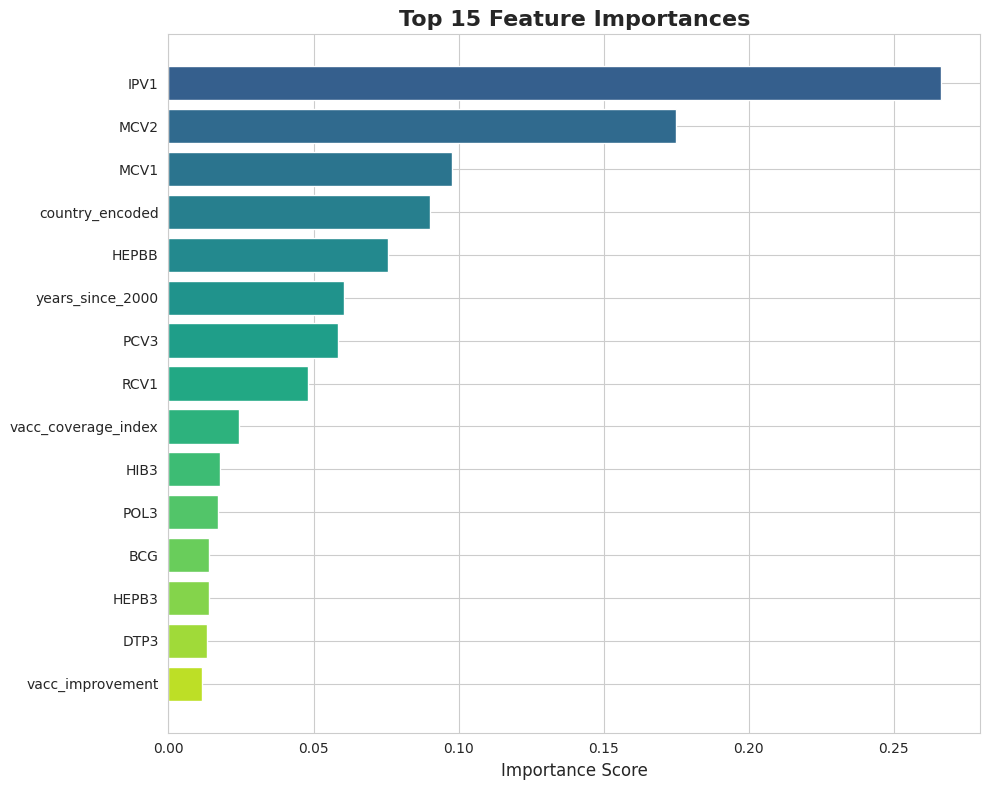

In [111]:
# Plot feature importance
plt.figure(figsize=(10, 8))
top_15 = feature_importance.head(15)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_15)))
plt.barh(range(len(top_15)), top_15['importance'], color=colors)
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 15 Feature Importances', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [112]:
# Error analysis by country
test_indices = y_test.index
test_results = df_cleaned.loc[test_indices, ['country', 'year']].copy()
test_results['actual'] = y_test.values
test_results['predicted'] = y_pred_final
test_results['error'] = np.abs(y_test.values - y_pred_final)

worst_predictions = test_results.nlargest(10, 'error')
print("\nTop 10 Countries/Years with Highest Prediction Errors:")
print(worst_predictions.to_string(index=False))


Top 10 Countries/Years with Highest Prediction Errors:
                 country  year  actual  predicted     error
Central African Republic  2009  14.665  49.241997 34.576997
             South Sudan  2017  35.351  51.739428 16.388428
             South Sudan  2016  36.720  47.156216 10.436216
                 Nigeria  2020  53.072  61.200312  8.128312
                   Haiti  2009  61.694  53.981562  7.712438
                   Samoa  2006  71.620  64.175957  7.444043
             South Sudan  2015  39.757  47.048220  7.291220
                 Nigeria  2021  53.455  60.701536  7.246536
                 Lesotho  2017  53.874  61.091754  7.217754
                 Nigeria  2023  54.462  61.620440  7.158440


# 10. Save Model

In [116]:
# Save model and preprocessing objects
joblib.dump(final_model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le_country, 'label_encoder.pkl')
joblib.dump(feature_cols, 'feature_columns.pkl')
joblib.dump(df_cleaned, 'cleaned_dataset.pkl')
# joblib.dump(imputer, 'imputer.pkl')

['cleaned_dataset.pkl']